# Next Fare Predictor
***

Bonus question:  
**To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.**

In [1]:
# change main root dir
%cd ..\..

D:\Projects\CondaAnalyses\PMI


In [2]:
import os
import gc
import numpy as np
import pandas as pd
import geopy
import geopandas as gpd
import seaborn as sns
from random import randint
from datetime import datetime
import matplotlib.pyplot as plt
import folium
import utilities
from functools import reduce
data_path = 'data_checkpoints/usecase_cab/'

In [3]:
flatui = ["#9225a5", "#82c7a5", "#0145ac", "#eece1a", "#f4d6ad", "#f15e22"]
sns.set_style(
    "darkgrid",
    {

        "grid.linestyle": ":",
        'axes.facecolor':'#1B212C'
    }
)
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

In [4]:
base_df = pd.read_csv(data_path+'clean_cabspotting_df.csv', index_col=0)
origin_destination_df = pd.read_csv(data_path+'origin_destination_coordinates.csv', index_col=0)

dfs = [base_df,  origin_destination_df]

# merge dataframes
df = reduce(lambda  left,right:
            pd.merge(left, right, on=['id']),
            dfs)

# Keep RAM happy
del base_df, origin_destination_df, dfs
gc.collect()

df['time']= pd.to_datetime(df['time'])
df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709


***

In [5]:
# Add immediate next events origin latitudes and longitudes 

df['next_event_origin_latitude'] = (
    df.sort_values(['id', 'time'])
    ['latitude'].shift(-1)
)
df['next_event_origin_longitude'] = (
    df.sort_values(['id', 'time'])
    ['longitude'].shift(-1))
df.head()

next_event_origin_latitude_df = (
    df.sort_values(['time'])
    .groupby('id_event')
    ['next_event_origin_latitude'].last()
    .to_frame()
    .reset_index()
    )

next_event_origin_longitude_df = (
    df.sort_values(['time'])
    .groupby('id_event')
    ['next_event_origin_longitude'].last()
    .to_frame()
    .reset_index()
)

# Modify next event origin lat,lon based on occupancy state change
df = df.drop(
    ['next_event_origin_latitude', 'next_event_origin_longitude'], 
    axis=1
)

df = pd.merge(df, next_event_origin_latitude_df, on='id_event')
df = pd.merge(df, next_event_origin_longitude_df, on='id_event')

del next_event_origin_latitude_df, next_event_origin_longitude_df
gc.collect()

df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724


In [6]:
unnocupied_df = (
    df[df['occupancy']==0]
    .sort_values(['time'])
    .groupby('id_event')
    .first()
)
unnocupied_df.head(1)

,id,file_name,latitude,longitude,time,occupancy,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude
id_event,,,,,,,,,,,,,,
abboip_1211033530,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724


In [14]:
# Get the distance between end of fare and next pick-up
unnocupied_df = utilities.append_haversine_distance(
    unnocupied_df,
    'id_event',
    'destination_latitude',
    'destination_longitude',
    'next_event_origin_latitude',
    'next_event_origin_longitude')
unnocupied_df.head(3)

,id,file_name,latitude,longitude,time,occupancy,travelled_distance_km_x,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude,travelled_distance_km_y,travelled_distance_km
id_event,,,,,,,,,,,,,,,,
abboip_1211033530,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,0.013266,0.013266
abboip_1211036160,abboip_1211036160,abboip,37.75580,-122.41441,2008-05-17 14:56:00,0,0.815618,1315.0,37.75580,37.75053,-122.41441,-122.42086,37.75177,-122.43095,0.899804,0.899804
abboip_1211037710,abboip_1211037710,abboip,37.75177,-122.43095,2008-05-17 15:21:50,0,2.485586,1285.0,37.75177,37.77181,-122.43095,-122.41836,37.75240,-122.41842,2.154361,2.154361


In [15]:
# calculate the error in km
mse = sum(
    unnocupied_df['travelled_distance_km_y']
    *unnocupied_df['travelled_distance_km_y']
)/len(unnocupied_df['travelled_distance_km_y'])
print(f'The mean squared error is: {mse}km or 0.6miles')

The mean squared error is: 1.577255465239175km or 0.6miles


***

In [9]:
# Decomposing time to explore taxi occupancy
df['week_day'] = df['time'].dt.dayofweek
df['hour'] = df['time'].dt.hour
df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude,week_day,hour
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14


In [10]:
# bucketing of time
event_id_hours = df.sort_values(['time']).groupby(by=['id_event']).hour
event_start_hour = event_id_hours.first().to_frame()
event_end_hour = event_id_hours.last().to_frame()

def bin_hour(val):
    if 6 < val < 12:
        return "morning"
    elif 12 < val < 18:
        return "afternoon"
    elif 18 < val < 24:
        return "night"
    else:
        return "late"
    
time_bin_event_start = (
    event_start_hour['hour']
    .apply(bin_hour)
    .to_frame()
    .rename(columns={'hour': 'start_time_of_day'})
)
time_bin_event_end = (
    event_start_hour['hour']
    .apply(bin_hour)
    .to_frame()
    .rename(columns={'hour': 'end_time_of_day'})
)

In [11]:
df = pd.merge(df, time_bin_event_start.reset_index(), on="id_event")
df = pd.merge(df, time_bin_event_end.reset_index(), on="id_event")
del time_bin_event_start, time_bin_event_end
gc.collect()
df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude,week_day,hour,start_time_of_day,end_time_of_day
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon


***

In [12]:
# Group by event bin
events_df = df.sort_values(['time']).groupby(by=['id_event']).first()
events_df.head(2)

,id,file_name,latitude,longitude,time,occupancy,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude,week_day,hour,start_time_of_day,end_time_of_day
id_event,,,,,,,,,,,,,,,,,,
abboip_1211033530,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
abboip_1211035870,abboip_1211035870,abboip,37.74977,-122.39724,2008-05-17 14:51:10,1,1.639782,288.0,37.74977,37.75552,-122.39724,-122.41438,37.75580,-122.41441,5,14,afternoon,afternoon


In [30]:
events_df.groupby(by="start_time_of_day").count()

,id,file_name,latitude,longitude,time,occupancy,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude,week_day,hour,end_time_of_day
start_time_of_day,,,,,,,,,,,,,,,,,
afternoon,102151,102151,102151,102151,102151,102151,102151,102151,102151,102151,102151,102151,102151,102151,102151,102151,102151
late,265809,265809,265809,265809,265809,265809,265809,265809,265809,265809,265809,265809,265809,265809,265809,265809,265809
morning,82750,82750,82750,82750,82750,82750,82750,82750,82750,82750,82750,82750,82750,82750,82750,82750,82750
night,115070,115070,115070,115070,115070,115070,115070,115070,115070,115070,115070,115070,115070,115070,115070,115070,115070


([<matplotlib.patches.Wedge at 0x2104825ebf0>,
 [Text(1.0878834710375909, 0.16281754648441157, '14'),
  Text(0.972784221573536, 0.5135083818766447, '15'),
  Text(0.7011729719701303, 0.8475591208751015, '16'),
  Text(0.3164018656359285, 1.0535131035834837, '17'),
  Text(-0.10464770573589871, 1.0950108938655418, '18'),
  Text(-0.5116439150554375, 0.9737661445063411, '19'),
  Text(-0.8352215807025127, 0.7158246371345403, '20'),
  Text(-1.0256959556318288, 0.39742647949087384, '21'),
  Text(-1.0964718470227368, 0.08803118019513499, '22'),
  Text(-1.0887219692815635, -0.15711293264296994, '1'),
  Text(-1.0572725630866289, -0.3036029106320134, '2'),
  Text(-1.0295975236638781, -0.3872065847389607, '3'),
  Text(-0.9989184996801765, -0.4606102810366972, '4'),
  Text(-0.9484371159542212, -0.5571956901129435, '5'),
  Text(-0.8513466073659426, -0.6965694180241476, '6'),
  Text(-0.6714057143306708, -0.8713290806372308, '7'),
  Text(-0.40682403510540927, -1.0220049923853372, '8'),
  Text(-0.1104285

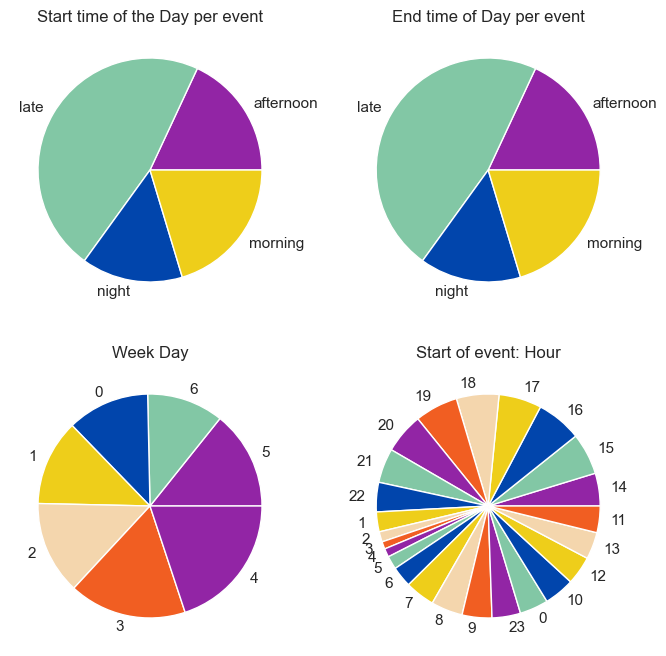

In [38]:
fig = plt.figure(figsize=(8, 8))

#axs[0, 0].set_title('Time of the day: Start of Event')
fig.add_subplot(221).set_title('Start time of the Day per event')
plt.pie(
    events_df.groupby(by="start_time_of_day").count()['id'],
    labels=events_df["start_time_of_day"].unique(),
    colors = sns.color_palette(flatui)
)

# axs[0, 1].set_title('Time of the day: End of Event')
# plt.pie(x="end_time_of_day" ,data=events_df, ax=axs[0, 1])
fig.add_subplot(222).set_title('End time of Day per event')
plt.pie(
    events_df.groupby(by="end_time_of_day").count()['id'],
    labels=events_df["end_time_of_day"].unique(),
    colors = sns.color_palette(flatui)
)

# fig.add_subplot(223).set_title('Start of event: Day of Week')
# plt.pie(x="week_day" ,data=events_df)
fig.add_subplot(223).set_title('Week Day')
plt.pie(
    events_df.groupby(by="week_day").count()['id'],
    labels=events_df["week_day"].unique(),
    colors = sns.color_palette(flatui)
)

fig.add_subplot(224).set_title('Start of event: Hour')
#sns.countplot(x="hour" ,data=events_df)
plt.pie(
    events_df.groupby(by="hour").count()['id'],
    labels=events_df["hour"].unique(),
    colors = sns.color_palette(flatui)
)

# fig.add_subplot(225).set_title('Duration of event: Hour')
# sns.lineplot(data=events_df, x='hour', y='event_duration')

# fig.add_subplot(226).set_title('Duration of event: Day of Week')
# sns.lineplot(data=events_df, x='week_day', y='event_duration')

In [39]:
occupied_cab_event_df = events_df[events_df['occupancy'] == 1]

In [40]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'Events per Cluster')

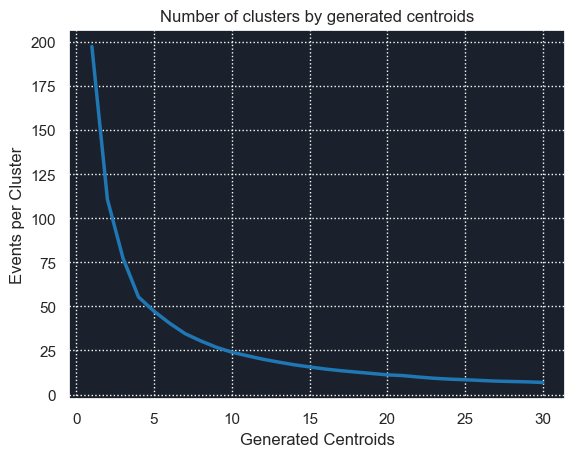

In [41]:
pickup_cluster = (
    occupied_cab_event_df[
        ['origin_latitude', 'origin_longitude']
    ].reset_index(drop=True)
)

## Find how many centroids make sense to apply kmeans
clusters = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pickup_cluster)
    clusters.append(kmeans.inertia_)

fig = plt.figure()
plt.plot(range(1, 31), clusters)
plt.grid(True)
plt.title('Number of clusters by generated centroids')
plt.xlabel('Generated Centroids')
plt.ylabel('Events per Cluster')

In [42]:
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(pickup_cluster)
centroids = kmeans.cluster_centers_

In [43]:
# Plotting the centroids on google map using Folium library.
SFO_COORDSINATES = 37.733795, -122.446747

map = folium.Map(location=[SFO_COORDSINATES[0], SFO_COORDSINATES[1]], zoom_start = 10)
folium.Marker([SFO_COORDSINATES[0], SFO_COORDSINATES[1]]).add_to(map)
for centroid in centroids: 
    folium.Marker([centroid[0], centroid[1]], icon=folium.Icon(color="orange", icon="arrow-down")).add_to(map)
map

In [44]:
centroid_cluster_df = unnocupied_df[
    [
        'time',
        'origin_latitude',
        'origin_longitude',
        'destination_latitude',
        'destination_longitude'
]].sort_values('time')
centroid_number = kmeans.predict(centroid_cluster_df[['origin_latitude', 'origin_longitude']])
centroid_cluster_df['centroid_number'] = list(centroid_number)

In [45]:
centroid_cluster_df['centroid_latitude'] = centroid_cluster_df['centroid_number'].apply(lambda x: centroids[x][0])
centroid_cluster_df['centroid_longitude'] = centroid_cluster_df['centroid_number'].apply(lambda x: centroids[x][1])

In [46]:
def get_h_distance(df):
    """
    Method to calculate Haversine distance of two coordinates. 
    http://project-osrm.org/docs/v5.5.1/api/#general-options
    """
    
    coords_start = (df['destination_latitude'], df['destination_longitude'])
    coords_end = (df['centroid_latitude'], df['centroid_longitude'])
    
    h_distance = geopy.distance.distance(coords_start, coords_end).miles
    
    return h_distance

error_distance = centroid_cluster_df[['destination_latitude', 'destination_longitude', 'centroid_latitude', 'centroid_longitude']].apply(get_h_distance, axis=1)

In [47]:
mse = sum(error_distance*error_distance)/len(error_distance)
print(f'The mean squared error is: {mse}')

The mean squared error is: 1.648460087485094


In [ ]:
gc.collect()